In [1]:

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 11 15:24:57 2019

@author: jacob
"""

import h5py
import scipy.io as spio
import matplotlib.pyplot as plt
import numpy as np
from cmocean import cm as cmo
from scipy.interpolate import griddata
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#from matplotlib.mlab import griddata
import datetime as dt
import gsw
import scipy.interpolate as interp
from matplotlib.gridspec import GridSpec
#%%
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 14
plt.rcParams['contour.negative_linestyle'] = 'solid'

In [2]:
#%% LOAD DYE DATA
filename = '/home/jacob/dedalus/LATMIX/LatMix_2012/my_triaxus_SI2'
filename = '/data/pacific/jacob/LATMIXDYE/LatMix_2012_Transfer/my_triaxus_SI2'
matfile = spio.loadmat(filename,struct_as_record=True, squeeze_me=True)


depth = matfile['DEPTH']
fluorppb = matfile['FLUORPPB']
shiplog = matfile['SHIPLOG']
rho = matfile['PDENS']
T = matfile['TEMP']
S = matfile['SALIN']
head = matfile['HEADING']
jday = matfile['JDAY']
lat = matfile['LAT']
lon = matfile['LON']
II = matfile['II'] # This indexes individual gulf stream crossings

fluorppb[np.isnan(fluorppb)] = 0
fluorppb[fluorppb<0] = 0
fluorppb[fluorppb==0] = 1e-10
nd, ns = shiplog.shape

#%% LOAD TIMESERIES DATA

jday_ts = matfile['jday_ts']
fluorppb_ts = matfile['fluorPPB_ts']
depth_ts = matfile['depth_ts']
lat_ts = matfile['lat_ts']
lon_ts = matfile['lon_ts']
rho_ts = matfile['pdens_ts']
T_ts = matfile['T_ts']
S_ts = matfile['S_ts']
shiplog_ts = matfile['shiplog_ts']
ii = matfile['ii']
#%% LOAD FLOAT DATA
filename = '/home/jacob/dedalus/LATMIX/FloatData/Mar05_SI_2_Track.mat'
filename = '/data/pacific/jacob/LATMIXDYE/FloatData_Transfer/Mar05_SI_2_Track.mat'
matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)
floatstruct = matfile['F']
flat = floatstruct.lat
flon = floatstruct.lon
fyd = floatstruct.yd-1 #Craig convention

fyds = floatstruct.yds - 1
flats = floatstruct.lats
flons = floatstruct.lons

flatsm = floatstruct.lats*111e3
flonsm = floatstruct.lons*111e3*np.cos(floatstruct.lats*np.pi/180)
fvellat = np.gradient(flatsm)/np.gradient(fyds*86400) #Float velocity in latitude d lat/dt
fvellon = np.gradient(flonsm)/ np.gradient(fyds*86400) #Float velocity in longitude d lon/dt
#fdir = np.arctan2(fvellat, fvellon)

filename = '/home/jacob/dedalus/LATMIX/FloatData/Env.mat'
filename = '/data/pacific/jacob/LATMIXDYE/FloatData_Transfer/Env.mat'

matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)
fT = matfile['T']
fS = matfile['S']
fT = np.mean(fT, axis=-1)# Top and bottom sensors
fS = np.mean(fS, axis=-1)
fydr = matfile['yd'] - 1
fP = matfile['P']


In [187]:
filename = '/data/pacific/jacob/LATMIXDYE/LatMix_2012_Transfer/my_triaxus_SI2'
matfile = spio.loadmat(filename,struct_as_record=True, squeeze_me=True)
matfil

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Tue Feb 16 20:22:10 2016',
 '__version__': '1.0',
 '__globals__': [],
 'depth_ts': array([-0.39381772, -0.38991285, -0.38146621, ..., -0.51995926,
        -0.53402334, -0.55560934]),
 'T_ts': array([11.47435417, 11.49093   , 11.49497   , ..., 17.0784925 ,
        17.10890583, 17.14823583]),
 'S_ts': array([0.86961763, 0.91700253, 0.85755571, ..., 0.1588172 , 0.15645022,
        0.16348623]),
 'rhd_ts': array([0.05423285, 0.05245222, 0.05280835, ..., 0.        , 0.        ,
        0.        ]),
 'fluor_ts': array([0.0818071 , 0.0820106 , 0.0818071 , ..., 0.0442613 , 0.04558405,
        0.03042328]),
 'fluorClean_ts': array([ 0.01975109,  0.01996703,  0.01976656, ..., -0.01338582,
        -0.0120504 , -0.02719478]),
 'fluorPPB_ts': array([ 0.02325726,  0.02351294,  0.02327721, ..., -0.01608327,
        -0.01448033, -0.03268316]),
 'lat_ts': array([38.42067193, 38.42068056, 38.42067952, ..., 39.62141355,
        39.621402

## Calculate depth integrated quantities

In the following cell we calculate depth integrated quantities from the gridded data
(ex. vertically integrated dye concentration)

In [4]:
#%% Calculated depth integrated 


fluor_int = np.zeros((ns,))
lat_int = np.zeros((ns,))
lon_int = np.zeros((ns,))
jday_int = np.zeros((ns,))
surf_rho = np.zeros((ns,))
shiplog_int = np.zeros((ns,))
zcom_rho = np.zeros((ns,))
zcom_t = np.zeros((ns,))
zcom_s = np.zeros((ns,))
zcom_si = np.zeros((ns,))
zcom_ti = np.zeros((ns,))
for i in range(0, ns):
    mask = np.isfinite(fluorppb[:,i])
    fluor_int[i] = integrate.trapz(fluorppb[mask,i], x=depth[mask,i])
    shiplog_int[i] = np.nanmean(shiplog[mask,i])
    lat_int[i] = np.nanmean(lat[:,i])
    lon_int[i] = np.nanmean(lon[:,i])
    jday_int[i] = np.nanmean(jday[:,i])
    ind = np.where(np.isfinite(rho[:,i]))[0][0]
    zcom = integrate.trapz(fluorppb[mask,i]*depth[mask,i], x=depth[mask,i])/fluor_int[i]
    surf_rho[i] = rho[ind,i]
    ind = np.argmin(np.abs(depth[:,i] - zcom))
    zcom_rho[i] = rho[ind,i]
    zcom_t[i] = T[ind,i]
    zcom_s[i] = S[ind,i]
    mask = np.logical_and(mask, np.isfinite(T[:,i]+S[:,i]))
    zcom_ti[i] = integrate.trapz(fluorppb[mask,i]*T[mask,i], x=depth[mask,i])/fluor_int[i]
    zcom_si[i] = integrate.trapz(fluorppb[mask,i]*S[mask,i], x=depth[mask,i])/fluor_int[i]


# calc distance relative to float
iflat = np.interp(jday_int, fyds, flats)
iflon = np.interp(jday_int, fyds, flons)
distlat = (lat_int-iflat)*111e3
distlon = (lon_int-iflon)*111e3*np.cos(lat_int*np.pi/180)

fdist = np.sign(lat_int-iflat)*np.sqrt((distlat)**2 + (distlon)**2)

## Integrated by crossing

Here we treat each crossing as a distinct observation.

This is where we project the crossings into a direction/distance orthogonal to the float's direction of travel.

For each survey (as indexed in II) we:

1) Calculate the closest point of approach and find the index of that observation (distind)

2) Figure out the direction of the survey (survang)

3) Figure out the direction of the float's travel (fang)

4) Project the survey distance orthogonal to the float's dir of travel (shiplogc)


To do this, note that shiplog_int is in km. We first find the velocity 

In [5]:
#%% INTEGRATED BY CROSSING

nc, nl = II.shape
survdist = np.zeros((ns,))
weightedrho = np.zeros((nc,))
ydc = np.zeros((nc,))
shiplogc = np.zeros((nd, ns))
for i in range(0, nc-1):
    span = range(II[i,0], II[i,1])
    
    # Calculate closest point of ship approach
    meanfloatlat = np.interp(np.mean(jday_int[span]), fyds, flats) # What is the float lat during the survey average?
    meanfloatlon = np.interp(np.mean(jday_int[span]), fyds, flons) # What is the float lon during the survey average?
    distlat = (lat_int[span]-meanfloatlat)*111e3 # How far (m) in latitude dir was the ship from the float?
    distlon = (lon_int[span]-meanfloatlon)*111e3*np.cos(lat_int[span]*np.pi/180) # How far (m) in longitude dir was ship from float?
    distspan = np.sign(distlat)*np.sqrt(distlat**2 + distlon**2) # Total distance (m)
    distind = np.argmin(np.abs(distspan))

#    tempdist = distspan - distspan[distind] # This is distance from the closest point of approach to the float for a survey
    
    #Calculate angle of ship track 
    # Using survey as straight line
    latdm = (lat_int[span[-1]] - lat_int[span[0]])*111e3
    londm = (lon_int[span[-1]] - lon_int[span[0]])*111e3*np.cos(lat_int[span]*np.pi/180)
    # At each point
    latdm = np.gradient(lat_int[span]*111e3)
    londm = np.gradient(lon_int[span]*111e3*np.cos(lat_int[span]*np.pi/180))
    
    survang = np.arctan2(latdm,londm ) #angle of survey (cart coords)
    
    #survang = np.arctan2((lat_int[span[-1]] - lat_int[span[0]]), (lon_int[span[-1]] - lon_int[span[0]])) #angle of survey (geo coords)
    
    fvellatm = np.mean(np.interp(jday_int[span], fyds, fvellat)) # mean float latitude velocity during survey
    fvellonm = np.mean(np.interp(jday_int[span], fyds, fvellon)) # mean float longitude velocity during survey
    fang = np.arctan2(fvellatm, fvellonm) # angle of float velocity (cart) XXX - are these accurate calcs?
#    print(survang*180/np.pi)
    angdif = survang - fang # Difference in angle between float direction and survey
#    angdif = (angdif+np.pi) % (2*np.pi) - np.pi

    factor = np.sin(angdif) # Project the survey on a direction orthogonal to float travel
    #factor = 1

    survdist[span] = (shiplog_int[span] - shiplog_int[span][distind])*factor # XXX Check this.
#    survdist[span] = tempdist*np.abs(factor)
    shiplogc[:,span] = (shiplog[:,span] - shiplog[:,span][:,distind][:,np.newaxis])*factor # THIS WORKS ONLY FOR THE STRAIGHT LINE SURVEY PROJECTION
    
    dship = np.gradient(shiplog[:,span], axis=-1)
    shiplogc[:,span] = integrate.cumtrapz(dship*factor, axis=-1, initial=0)
    shiplogc[:,span] = shiplogc[:,span] - shiplogc[:,span][:,distind][:,np.newaxis]
    if i == 8:
        #print(fang*180/np.pi)
        print(survang*180/np.pi)
        print(head[300,span])
        #print(angdif*180/np.pi)
        #print(factor)
        #print(shiplogc[100,span])
        #print(shiplog[100,span]-shiplog[100,span][distind])
        #plt.pcolor(shiplogc[:,span])
        #plt.colorbar()
#    print(survang*180/np.pi)
    ftemp = fluorppb[:,span]
    rtemp = rho[:,span]
    ftemp[~np.isfinite(ftemp)] = 0
    rtemp[~np.isfinite(rtemp)] = 0
    sltemp = shiplogc[:,span]
    sltemp[~np.isfinite(sltemp)] = 0
    weightedrho[i] = np.trapz(np.trapz(ftemp*rtemp, x=sltemp, axis=-1), x=depth[:,span[0]], axis=0)/np.trapz(np.trapz(ftemp, x=sltemp, axis=-1), x=depth[:,span[0]], axis=0)
    ydc[i] = np.nanmean(jday[:,span])

/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


[47.67898934 47.05803233 47.31165424 50.47116373 54.03053055 56.94419564
 58.21941948 56.05370796 50.04341688 47.05903897 40.64001457 30.08901119
 20.38670025 16.31033871 15.63080786]
[ 12.14626917  22.37889761   8.17696083  13.83366252 297.14918108
   9.13119582  89.22474892 356.66283353  20.45268932  10.83332722
  28.35788101  38.9095208   66.08954293  71.3730931   95.67452699]


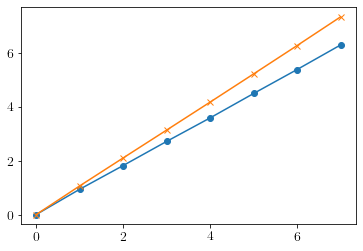

In [175]:
slm = np.nanmean(shiplog[:,span], axis=0)
plt.plot(slm-slm[0], '-o')
distlat = np.cumsum(latdm)
distlon = np.cumsum(londm)
plt.plot(np.sqrt((distlat-distlat[0])**2 + (distlon-distlon[0])**2)/1000, '-x')

In [174]:
latdm = np.gradient(lat_int[span]*109e3)
latdm.shape

(8,)

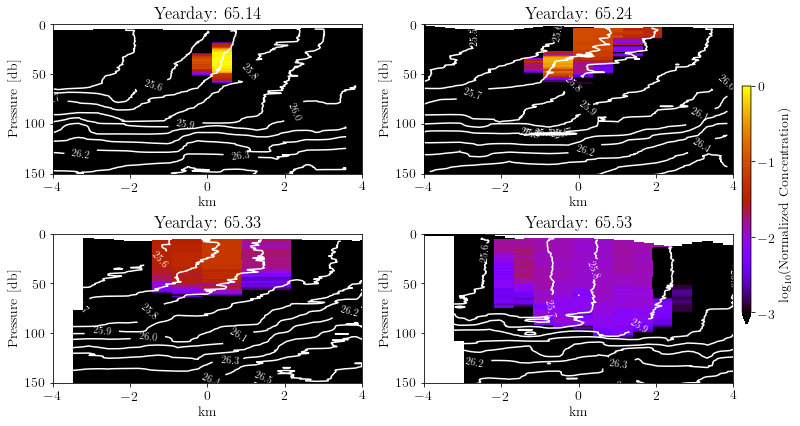

In [674]:
#%% Plot 4 panel
##################### NOT INTERPOLATED #####################################
cmap = 'gnuplot'
conts = np.linspace(-3, 0, 13)

crossings = [6, 8, 12, 14] # pcik the sections 
crossings = [4, 6, 8, 10]
crossings = [4,  6, 8, 12]
#crossings = [0, 1, 2, 3]
xcrosslims = [[-5, 5], [-5, 5], [-4, 6], [-7, 3]]
xcrosslims = [[-5, 5], [-5, 5], [-4, 6], [-4, 6]]
xcrosslims = [[-4, 4], [-4, 4], [-4, 4], [-4, 4]]

#crossings = [4, 6, 7, 8]
norm = np.nanmax(fluorppb)


fig=plt.figure(figsize=(12.2,6.6))

gs=GridSpec(2,2) # 3 rows, 2 columns
axs = {}
axs['1']=fig.add_subplot(gs[0,0]) # First row, first column
axs['2']=fig.add_subplot(gs[0,1]) # First row, second column
axs['3']=fig.add_subplot(gs[1,0]) # First row, first column
axs['4']=fig.add_subplot(gs[1,1]) # First row, second column

cl = [0.001, 1]
cl = [-3, 0]
rhoc = np.linspace(20, 30, 101)+0.1
dyeconts = np.linspace(-3, 0, 13)
# First section
for i in range(1, len(crossings)+1):
    
    span = range(II[crossings[i-1],0], II[crossings[i-1],1])
    #ls = int(len(span)/2)
    #X = shiplog[:,span] - shiplog[:,span[ls]][:,np.newaxis]
    #X = shiplogc[:,span]
    #Y = depth[:,span]
    #C = fluorppb[:,span]/norm
    #C[~np.isfinite(C)] = 0
    #R = rho[:,span]
    #R[~np.isfinite(R)] = 0
    
    X,Y, C, R, shiplogobs, depthobs = getProjectedSection(crossings[i-1])
    Xp = np.zeros(X.shape)
    Xp[:,1:] = 0.5*(X[:,1:] + X[:,0:-1])
    Xp[:,0] = -5
    im = axs[str(i)].pcolor(Xp, Y, np.log10(C), vmin=cl[0], vmax=cl[1], cmap=cmap)
    im.set_edgecolor('face')
    #im = axs[str(i)].contour(X, Y, np.log10(C), dyeconts, vmin=cl[0], vmax=cl[1],  extend='min', colors='w')
    
    mask = np.isfinite(X+Y+R)
    X = np.ma.masked_where(~np.isfinite(X+Y+R), X)
    Y = np.ma.masked_where(~np.isfinite(Y+X+R), Y)
    R = np.ma.masked_where(~np.isfinite(X+Y+R), R)

    cs = axs[str(i)].contour(Xp, Y, R,rhoc, colors='w')
    axs[str(i)].clabel(cs, inline=1, fontsize=10, fmt='%1.1f')
    axs[str(i)].set_ylim(0, 150)
    axs[str(i)].invert_yaxis()
    axs[str(i)].set_xlabel('km')
    axs[str(i)].set_ylabel('Pressure [db]')
    axs[str(i)].set_title('Yearday: %2.2f' %np.nanmean(jday[:,span]))
    axs[str(i)].set_xlim(xcrosslims[i-1])
    
    #axs[str(i)].scatter(shiplogobs, depthobs, marker='x')
#    axs[str(i)].grid()


#test float data
#axs['5'].plot(fyd, flat)
# ADD COLORBAR
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.25, 0.01, 0.5])
cb = fig.colorbar(im, cax=cbar_ax, extend='min')
cb.set_ticks([-3, -2, -1, 0])
cb.set_label('log$_{10}$(Normalized Concentration)')
cb.solids.set_edgecolor("face")
plt.subplots_adjust(wspace=0.2, hspace=0.4)

#plt.savefig('/data/pacific/jacob/LATMIXDYE/NEWFIGS/DyeObsOverview_INT2.pdf', bbox_inches='tight')


In [666]:
Xp = np.zeros(X.shape)
Xp[:,1:] = 0.5*(X[:,1:] + X[:,0:-1])
Xp[:,0] = -5
Xp.shape

(1913, 100)

In [670]:
# DO INTERPOLATION FUNCTION

def getProjectedSection(crossing):
    span = range(II[crossing,0], II[crossing,1])
    span_ts = range(ii[crossing,0], ii[crossing,1])

    values = fluorppb[:,span]
    values[values<=0] = 1e-10
    values = values/np.nanmax(fluorppb)
    # Project to float normal coordinate system

    # First calc the survey mean float angle
    tmean = np.nanmean(jday[:,span])
    fvellatm = np.mean(np.interp(tmean, fyds, fvellat)) # mean float latitude velocity during survey
    fvellonm = np.mean(np.interp(tmean, fyds, fvellon)) # mean float longitude velocity during survey
    fang = np.arctan2(fvellatm, fvellonm) # angle of float velocity (cart) XXX - are these accurate calcs?
    # Then calculate survey angle relative to float 
    theta = -fang # 0 if pure zonal
    #theta = 0
    y = lat[:,span]*111e3 
    x = lon[:,span]*111e3*np.cos(lat[:,span]*np.pi/180)
    
    # Now calculate closest point of appraoch
    meanfloaty = np.interp(np.nanmean(jday[:,span]), fyds, flats)*111e3 # What is the float lat during the survey average?
    meanfloatx = np.interp(np.nanmean(jday[:,span]), fyds, flons*np.cos(flats*np.pi/180))*111e3 # What is the float lon during the survey average?
    #floatindx = np.nanargmin((x.ravel() - meanfloatx)**2 )
    #x = x - x.ravel()[floatindx]
    #floatindy = np.nanargmin((y.ravel() - meanfloaty)**2)
    #y = y - y.ravel()[floatindy]
    #print(floatind)
    x = x - meanfloatx
    y = y - meanfloaty
    
    #x = x-np.nanmin(x); y = y - np.nanmin(y)
    rotatedpoints = (x*np.cos(theta)-y*np.sin(theta), x*np.sin(theta)+y*np.cos(theta))
    shiplogc = rotatedpoints[1]/1000 
    
    #shiplogc = shiplogc - shiplogc[floatind]
    # Interpolate the data
    grid_x = np.linspace(-5, 5, 10*4)
    grid_y = depth[:,1]
    GX, GY = np.meshgrid(grid_x, grid_y)

    # ALTERNATELY INTERPOLATE 1D AT EACH DEPTH BIN
    deps = depth_ts[span]
    grc = np.zeros((grid_y.size, grid_x.size))
    R = np.zeros((grid_y.size, grid_x.size))
    sl = shiplogc
    #print(sl[100,:])
    for i in range(0, grid_y.size):
        vtemp = values[i,:]
        rtemp = rho[i,span]
        stemp = sl[i,:]
        #print(np.gradient(stemp)>0)
        m = (np.isfinite(vtemp)) & ~(np.insert(np.diff(stemp), 0, 0) <0)
        stemp = stemp[m]
        vtemp = vtemp[m]
        rtemp = rtemp[m]
        #inds = np.argsort(vtemp)
        grc[i, :] = interp.interp1d(stemp, vtemp, kind='nearest',bounds_error=False)(grid_x)
        R[i, :] = interp.interp1d(stemp, rtemp, kind='linear',bounds_error=False)(grid_x)

        #grc[i, :] = 10**interp.interp1d(sl[m], np.log10(values[m]), kind='slinear',bounds_error=False)(grid_x)

    points = (shiplogc.ravel(), depth[:,span].ravel() )
    rhov = rho[:,span].ravel()
    mask = np.isfinite(shiplogc.ravel() + depth[:,span].ravel()+rho[:,span].ravel())
    #R = griddata((shiplogc.ravel()[mask], depth[:,span].ravel()[mask]), rhov[mask], (GX, GY), method='linear', rescale=True)

    # Create mask of upper most depths (we don't want to extrapolate above tow-yo depths)
    depthnorm = depth[:,span]
    sli = np.zeros((len(span),))
    depthi = np.zeros((len(span)))
    for i in range(0,len(span)):
        depthi[i] = depth[np.where(np.isfinite(shiplog[:,span[i]]))[0][0],span[i]]
        sli[i] = shiplogc[np.where(np.isfinite(shiplog[:,span[i]]))[0][0],i]
    mindsi = np.interp(grid_x, sli, depthi)
    mindgrid = np.tile(mindsi, (grid_y.size, 1))
    
    grc[GY<mindgrid] = np.nan
    R[GY<mindgrid] = np.nan
    
    
    
    
    #Mask values outside the survey distance (y) direction
    #grc[GX>np.nanmax(shiplogc)] = np.nan
    #m = GX[0:300,:] >= np.nanmax(shiplogc[0:200,:])
    #gctemp = grc[0:300,:]
    #gctemp[m] = np.nan
    #grc[0:300,:] = gctemp
#for i in range(0,depth.shape[0]):
#    maxx = np.nanmax(shiplogc[i,:])
#    m = GX[i,:]>maxx
#    grc[i,m] = np.nan
#R[GX>np.max(points[0])] = np.nan
    shiplogobs = shiplogc.ravel()
    depthobs = depth[:,span].ravel()
    m = np.isfinite(shiplogobs+depthobs)
    shiplogobs = shiplogobs[m]
    depthobs = depthobs[m]
    return GX, GY, grc, R, shiplogobs, depthobs


In [669]:
GX.shape

(1913, 200)

In [560]:
depth[300,0]

30.0

In [537]:
## TO DO

# XX 1) Fix up the extrapolation limits (horizontal)
# XX 2) Normalize x by float location
# XX 3) Fix rho interpolation
# 4) Make into 4 panel
# 5) Remake animation

9.051136265132776

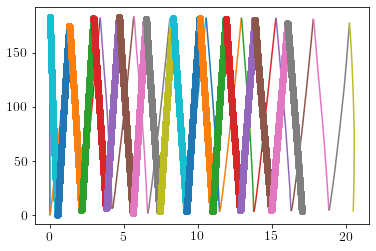

In [502]:
plt.plot(np.sqrt(x**2+y**2)/1000, depth[:,span])
plt.plot(shiplog[:,span]-np.nanmin(shiplog[:,span]), depth[:,span], marker='o')

In [946]:
# Try doing my own interpolation as a check...

crossing = 20
cl = [-3, 0]
#span = II[crossing,0:1]
#times = jday[span]
#span = range(II[crossing,0], II[crossing,1])
#times = (jday[:,span]).ravel()
#times = jday[1000,span]
#times = times[np.isfinite(times)]
#tsind = np.argmin(np.abs(jday_ts - times[0]))
#teind = np.argmin(np.abs(jday_ts - times[-1]))
tsind = ii[crossing,0]; teind=ii[crossing, 1]
span = range(tsind,teind)
#points = np.transpose(np.array(points))
values = fluorppb_ts[tsind:teind]
values[values<=0] = 1e-10
values = values/np.max(fluorppb_ts)
# Project to float normal coordinate system

# First calc the survey mean float angle
tmean = np.mean(jday_ts[span])
fvellatm = np.mean(np.interp(tmean, fyds, fvellat)) # mean float latitude velocity during survey
fvellonm = np.mean(np.interp(tmean, fyds, fvellon)) # mean float longitude velocity during survey
fang = np.arctan2(fvellatm, fvellonm) # angle of float velocity (cart) XXX - are these accurate calcs?
# Then calculate survey angle relative to float
#latdm = np.gradient(lat_ts[span]*111e3)/np.gradient(jday_ts[span])
#londm = np.gradient(lon_ts[span]*111e3*np.cos(lat_ts[span]*np.pi/180))/np.gradient(jday_ts[span])    
#survang = np.arctan2(latdm,londm ) #angle of survey (cart coords)
#angdif = survang - fang # Difference in angle between float direction and survey
#factor = np.sin(angdif) # Project the survey on a direction orthogonal to float travel
#factor=1
# Project the distance into float normal direction
#dship = np.gradient(shiplog_ts[span], axis=-1)
#shiplogc = integrate.cumtrapz(dship*factor, axis=0, initial=0)
#shiplogc = shiplogc[:,span] - shiplogc[span][:,distind][:,np.newaxis]    
theta = -fang # 0 if pure zonal
#theta = 0
y = lat_ts[span]*111e3 
x = lon_ts[span]*111e3*np.cos(lat_ts[span]*np.pi/180)
x = x-x[0]; y = y - y[0]
rotatedpoints = (x*np.cos(theta)-y*np.sin(theta), x*np.sin(theta)+y*np.cos(theta))
shiplogc = rotatedpoints[1]/1000

# Interpolate the data
grid_x = np.linspace(0, 10, 10*5)
grid_y = np.linspace(0, 150, 50)
#grid_y = depth[:,1]
GX, GY = np.meshgrid(grid_x, grid_y)
#points = (shiplog_ts[tsind:teind]-shiplog_ts[tsind], depth_ts[tsind:teind] )
points = (shiplogc, depth_ts[tsind:teind] )

#grc = griddata(points, values, (GX, GY), method='nearest', rescale=True)

# ALTERNATELY INTERPOLATE 1D AT EACH DEPTH BIN
deps = depth_ts[span]
sl = shiplogc
grc = np.zeros((grid_y.size, grid_x.size))
for i in range(1, grid_y.size-1):
    m = (deps > grid_y[i-1]) & (deps < grid_y[i+1])
#    m = (deps== grid_y[i])
    #grc[i, :] = np.interp(grid_x, sl[m], values[m])
    grc[i, :] = interp.interp1d(sl[m], values[m], kind='nearest',bounds_error=False)(grid_x)
    #grc[i, :] = 10**interp.interp1d(sl[m], np.log10(values[m]), kind='slinear',bounds_error=False)(grid_x)

# INTERPOLATE GRIDDED IN VERTICAL
#grid_y = depth[:,1] #Use Mile's grid
#y = lat[:,span]*111e3 
#x = lon_ts[span]*111e3*np.cos(lat_ts[span]*np.pi/180)
#x = x-x[0]; y = y - y[0]
#rotatedpoints = (x*np.cos(theta)-y*np.sin(theta), x*np.sin(theta)+y*np.cos(theta))
#shiplogc = rotatedpoints[1]/1000
#grc = np.zeros((grid_y.size, grid_x.size))
#for i in range(0, grid_y.size):
    
R = griddata(points, rho_ts[tsind:teind], (GX, GY), method='linear', rescale=True)


points = np.transpose(np.array((shiplogc, depth_ts[tsind:teind])))


    # Create mask of upper most depths (we don't want to extrapolate above tow-yo depths)
#depthnorm = depth[:,span]
sli = np.zeros((len(span),))
depthi = np.zeros((len(span)))
for i in range(0,len(span)):
    depthi[i] = depth[np.where(np.isfinite(shiplog[:,span[i]]))[0][0],span[i]]
    sli[i] = shiplogc[np.where(np.isfinite(shiplog[:,span[i]]))[0][0],i]
mindsi = interp.interp1d(sli, depthi, kind='linear', bounds_error=False, fill_value='extrapolate')(grid_x)
mindgrid = np.tile(mindsi, (grid_y.size, 1))
grc[GY<mindgrid] = np.nan
R[GY<mindgrid] = np.nan
# Mask the bottom of the domain
sli = np.zeros((len(span),))
depthi = np.zeros((len(span)))
for i in range(0,len(span)):
    depthi[i] = depth[np.where(np.isfinite(shiplog[:,span[i]]))[0][-1],span[i]]
    sli[i] = shiplogc[np.where(np.isfinite(shiplog[:,span[i]]))[0][-1],i]
mindsi = interp.interp1d(sli, depthi, kind='linear', bounds_error=False, fill_value='extrapolate')(grid_x)
mindgrid = np.tile(mindsi, (grid_y.size, 1))
grc[GY>mindgrid] = np.nan

    #Mask values outside the survey distance (y) direction
grc[GX>np.nanmax(shiplogc)] = np.nan
    
plt.figure(figsize=(10,4))
#plt.contourf(GX, GY, np.log10(grc), 100,vmin=cl[0], vmax=cl[1], cmap=cmap)
plt.pcolor(GX, GY, M)
plt.pcolor(GX, GY, np.log10(grc), vmin=cl[0], vmax=cl[1], cmap=cmap)
plt.contour(GX, GY, R, rhoc, colors='w')
#plt.scatter(shiplog_ts[tsind:teind]-shiplog_ts[tsind], depth_ts[tsind:teind], color='0.75', s = 7)
plt.scatter(shiplogc, depth_ts[tsind:teind], color='0.75', s = 7)
#plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r')

#plt.scatter(shiplog_ts[span]-shiplog_ts[span[0]], depth_ts[span], c=np.log10(var[span]),  vmin=cl[0], vmax=cl[1], cmap=cmap, s=200, marker='s')

#plt.plot(grid_x, mindsi,'x')
#plt.plot(shiplogc[minds], depthnorm[minds])
plt.ylim(0, 150)
plt.gca().invert_yaxis()
plt.xlabel('Cross-stream distance (km)')
plt.ylabel('z (m)')
plt.title('Nearest Neighbor')
#
#plt.savefig('./NEWFIGS/InterpTest_NEAREST3.pdf', bbox_inches='tight')

IndexError: index 85368 is out of bounds for axis 1 with size 1395

In [947]:
span.shape

AttributeError: 'range' object has no attribute 'shape'

In [864]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0


(50, 50)

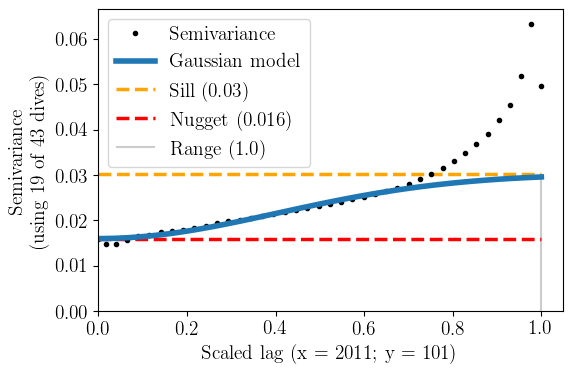

In [118]:
# Try other method of projection
import glidertools as gtt
import pykrige as pk
tsind = ii[2,0]; teind=ii[12, 1]
span = range(tsind,teind)

m = (depth_ts<100) & (jday_ts>66) & (jday_ts<68)

var = fluorppb_ts
var[var<=0] = 1e-10
var = var/np.max(var)

var = rho_ts
dives = np.zeros((len(depth_ts),))
for i in range(0, len(ii)):
    dives[ii[i,0]:ii[i,1]] = i
    
vargram = gtt.mapping.variogram(var, shiplog_ts, depth_ts,dives, max_points=20000,  mask=m, xy_ratio=5e-2)

In [133]:
grid_x = np.linspace(0, 15, 15*10)
grid_y = np.linspace(0, 150, 150)

crossing = 6
cl = [-3, 0]
tsind = ii[crossing,0]; teind=ii[crossing, 1]
span = range(tsind,teind)

var = fluorppb_ts
var[var<=0] = 1e-10
var = var/np.max(var)

interpolated = gtt.mapping.interp_obj(
    shiplog_ts[span]-shiplog_ts[span[0]], depth_ts[span], var[span], grid_x, grid_y,

    # Kriging interoplation arguments
    partial_sill=0.028,  # taken from the semivariogram (sill - nugget)
    nugget=0.014,  # taken from the semivariogram
    lenscale_x=10,  # in hours if x and xi are in datetime64
    lenscale_y=101,  # the vertical gridding influence
    detrend=True,  # if True use linear regression (z - z_hat), if False use average (z - z_mean)

    # Quadtree arguments
    max_points_per_quad=100,  # an optimsation setting ~100 is good
    min_points_per_quad=8,  # if neighbours have < N points, look at their neighbours

    # Parallel calculation inputs.
    n_cpus=1,  # the number of CPU's to use for the calculation - default is n-1
    parallel_chunk_size=512,  # when the dataset is very large, memory can become an issue
                              # this prevents large buildup of parallel results
)

Starting Interpolation with quadtree optimal interpolation
----------------------------------------------------------

Preparing for interpolations:
	Finding and removing nans
	Removing data trend with linear regression
	Building QuadTree

Interpolation information:
	basis points:        4326
	interp grid:         150, 150
	max_points_per_quad: 100
	min_points_per_quad: 8
	number of quads:     79
	detrend_method:      linear_regression
	partial_sill:        0.028
	nugget:              0.014
	lengthscales:        X = 10 
	                     Y = 101 m

Processing interpolation in 1 parts over 1 CPUs:
	chunk 1/1 completed in 9s

Finishing off interoplation
	Adding back the trend
	Creating xarray dataset for output


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/glidertools/helpers.py:69: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)
Process ForkPoolWorker-26:
Traceback (most recent call last):
  File "/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/multiprocessing/connection.py", line 21

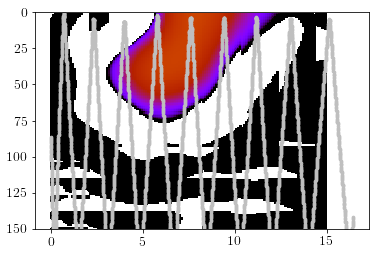

In [134]:
error_mask = (interpolated.variance / interpolated.nugget) < 1.05
interp_robust = interpolated.z.where(error_mask)

#plt.pcolor(grid_x, grid_y, interp_robust)
plt.pcolor(grid_x, grid_y, np.log10(interp_robust), vmin=cl[0], vmax=cl[1], cmap=cmap)
plt.scatter(shiplog_ts[tsind:teind]-shiplog_ts[tsind], depth_ts[tsind:teind], color='0.75', s = 7)


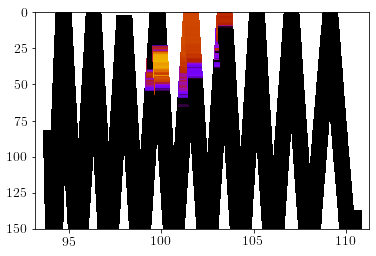

In [146]:
plt.scatter(shiplog_ts[span], depth_ts[span], c=np.log10(var[span]),  vmin=cl[0], vmax=cl[1], cmap=cmap, s=200, marker='s')
plt.ylim(0, 150)
plt.gca().invert_yaxis()

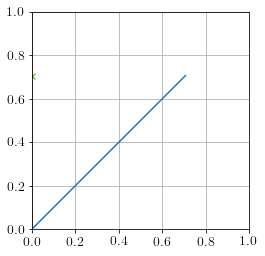

In [176]:
fang = 90*np.pi/180
theta = -fang # 0 if pure zonal
psi = 45*np.pi/180
x = np.real(np.linspace(0,1)*np.exp(1j*psi))
y = np.imag(np.linspace(0,1)*np.exp(1j*psi))
x = x-x[0]; y = y - y[0]

fx = np.real(np.linspace(0,1)*np.exp(1j*fang))
fy = np.imag(np.linspace(0,1)*np.exp(1j*fang))

rotatedpoints = (x*np.cos(theta)-y*np.sin(theta), x*np.sin(theta)+y*np.cos(theta))



plt.plot(x,y)
plt.plot(fx,fy)
plt.plot(rotatedpoints[0][-1]*fx[-1], rotatedpoints[0][-1]*fy[-1], marker='x')
#plt.plot(rotatedpoints[1][-1]*fx[-1], rotatedpoints[1][-1]*fy[-1]+fy[-1], marker='x')

plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0,1)


plt.grid()

(-5627620.3505625585, -5608103.022641405)

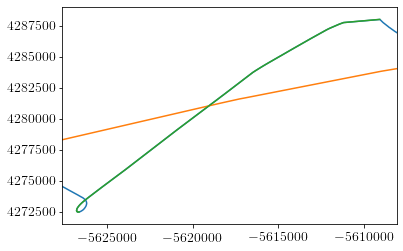

In [617]:
y = lat_ts[:]*111e3 
x = lon_ts[:]*111e3*np.cos(lat_ts[:]*np.pi/180)

plt.plot(x,y)

plt.plot(flons*111e3*np.cos(flats*np.pi/180), flats*111e3)
span = range(ii[4,0], ii[4,1])
y = lat_ts[span]*111e3 
x = lon_ts[span]*111e3*np.cos(lat_ts[span]*np.pi/180)

plt.plot(x,y)

plt.ylim(y[0]-1000, y[-1]+1000)
plt.xlim(x[0]-1000, x[-1]+1000)

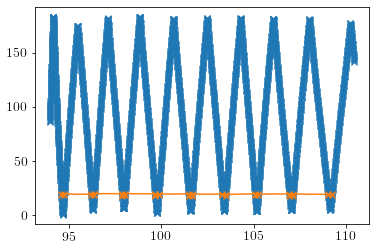

In [227]:
deps = depth_ts[span]
sl = shiplog_ts[span]
plt.plot(sl, deps, marker='x')
m = (deps<20)& (deps>18)
plt.plot(sl[m], deps[m], marker='x')

24.324324324324326


(0.001, 1)

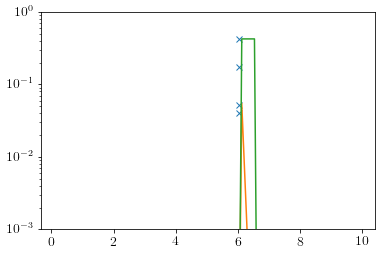

In [380]:
i = 12
print(grid_y[i])
m = (deps > grid_y[i-1]) & (deps < grid_y[i+1])
sl =    shiplogc
temp = 10**interp.interp1d(sl[m], np.log10(values[m]), kind='slinear',bounds_error=False)(grid_x)

plt.semilogy(sl[m], values[m], 'x')
plt.plot(grid_x, temp)
temp = interp.interp1d(sl[m], (values[m]), kind='nearest',bounds_error=False)(grid_x)
plt.plot(grid_x, temp)
plt.ylim(1e-3, 1)

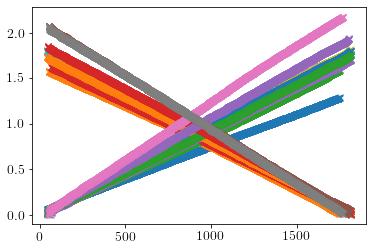

In [294]:
span = range(II[6,0], II[6,1])
ls = int(len(span)/2)
X = shiplog[:,span] - shiplog[:,span[ls]][:,np.newaxis]
plt.plot(np.diff(X), marker='x')

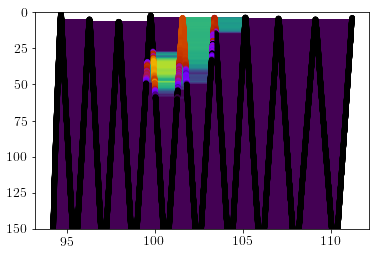

In [329]:
span = range(II[6,0], II[6,1])
C = fluorppb[:,span]/np.max(fluorppb)
plt.pcolor(shiplog[:,span], depth[:,span], np.log10(C), vmin=cl[0], vmax=cl[1])
plt.scatter(shiplog[:,span].ravel(), depth[:,span].ravel(), c = np.log10(C.ravel()), s=20, vmin=cl[0], vmax=cl[1], cmap=cmap)

plt.ylim(0, 150)
plt.gca().invert_yaxis()

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

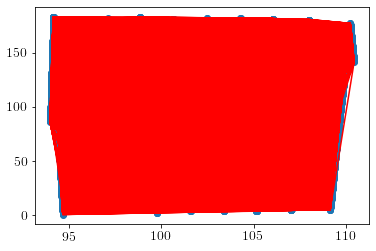

In [921]:
span = range(ii[6,0], ii[6,1])

from scipy.spatial import ConvexHull
from matplotlib.path import Path
from scipy.spatial import Delaunay

points = np.transpose(np.array((shiplog_ts[span], depth_ts[span])))
points[0].shape
#points = np.random.rand(14, 2)
hull = ConvexHull(points)
hull = Delaunay(points)
#hull_path = Path( points[hull.vertices] )

#print(hull_path.contains_point((1,2))) # Is (1,2) in the convex hull?

#plt.scatter(points[hull.vertices,0], points[hull.vertices,1])
plt.scatter(shiplog_ts[span], depth_ts[span])
plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r')

def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

in_hull(np.array((GX,GY)).T, hull)

In [755]:
from scipy.spatial import Delaunay
import numpy as np


def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

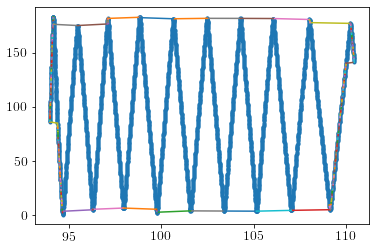

In [764]:
alpha = .4
points = np.array((shiplog_ts[span], depth_ts[span])).T
# Computing the alpha shape
edges = alpha_shape(points, alpha=1.2, only_outer=True)

# Plotting the output
plt.figure()
plt.plot(points[:, 0], points[:, 1], '.')
for i, j in edges:
    plt.plot(points[[i, j], 0], points[[i, j], 1])
    
hull_path = Path( points[hull.vertices] )


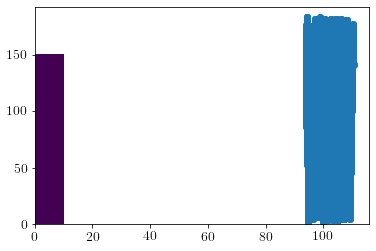

In [919]:
import alphashape

span = range(ii[6,0], ii[6,1])
points = np.transpose(np.array((shiplog_ts[span], depth_ts[span])))


alpha_shape = alphashape.alphashape(points, 0.5)
hull = alpha_shape.boundary

fig, ax = plt.subplots()
ax.scatter(*zip(*points))

M = in_hull(np.array((GX,GY)).T, hull).T
#x,y = alpha_shape.boundary.coords.xy
#ax.plot(x,y)
plt.pcolor(GX, GY, M)

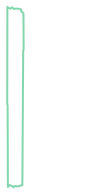

In [883]:
alpha_shape.boundary

In [927]:
Delaunay(np.transpose(np.array(alpha_shape.convex_hull.exterior.xy)))

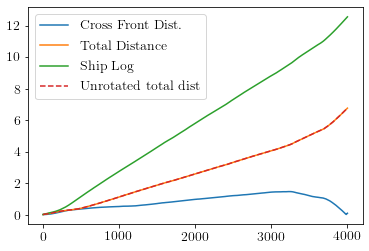

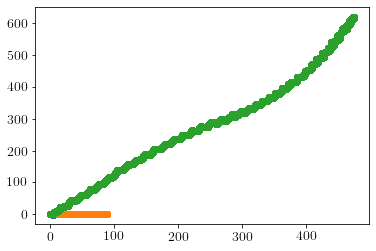

In [1046]:
# Confirm rotation
cross = 10

span = range(ii[cross,0], ii[cross, 1])
tmean = np.nanmean(jday_ts[span])
fvellatm = np.mean(np.interp(tmean, fyds, fvellat)) # mean float latitude velocity during survey
fvellonm = np.mean(np.interp(tmean, fyds, fvellon)) # mean float longitude velocity during survey
fang = np.arctan2(fvellatm, fvellonm) # angle of float velocity (cart) XXX - are these accurate calcs?
    # Then calculate survey angle relative to float 
theta = -fang # 0 if pure zonal
    #theta = 0
y = (lat_ts[span])*111e3 
x = (lon_ts[span]*np.cos(lat_ts[span]*np.pi/180))*111e3
#x, y = proj.transform(crs_wgs, crs_bng, lon_ts[span], lat_ts[span])
P = proj.Proj(proj='utm', zone=31, ellps='WGS84', preserve_units=True)
x, y = P(lat_ts[span], lon_ts[span])

    # Now calculate closest point of appraoch
meanfloaty = np.interp(np.nanmean(jday_ts[span]), fyds, flats)*111e3 # What is the float lat during the survey average?
meanfloatx = np.interp(np.nanmean(jday_ts[span]), fyds, flons*np.cos(flats*np.pi/180))*111e3 # What is the float lon during the survey average?
    #floatindx = np.nanargmin((x.ravel() - meanfloatx)**2 )
    #x = x - x.ravel()[floatindx]
    #floatindy = np.nanargmin((y.ravel() - meanfloaty)**2)
    #y = y - y.ravel()[floatindy]
    #print(floatind)
x = x - x[0]
y = y - y[0]
    
    #x = x-np.nanmin(x); y = y - np.nanmin(y)
rotatedpoints = (x*np.cos(theta)-y*np.sin(theta), x*np.sin(theta)+y*np.cos(theta))
shiplogc = rotatedpoints[1]/1000 

plt.plot(np.abs(rotatedpoints[1])/1000, label='Cross Front Dist.')
plt.plot(np.sqrt(rotatedpoints[1]**2+rotatedpoints[0]**2)/1000, label='Total Distance')

plt.plot(shiplog_ts[span]-shiplog_ts[span[0]], label='Ship Log')
plt.plot(np.sqrt(x**2 + y**2)/1000, label='Unrotated total dist', linestyle='--')
#plt.plot(shiplog_ts[span]-shiplog_ts[span[0]] + fvellatm * (jday_ts[span]-jday_ts[span[0]])*86400/1000, label='Shiplog + lat drift float')
plt.legend()
#plt.axhline(distance/1000)
plt.figure()
plt.scatter(x/1000, y/1000)
plt.scatter(flonmi/100, flatmi/1000)
plt.scatter(xn/1000, yn/1000)

In [984]:
flatmi = np.interp(jday_ts[span], fyds, flatsm)
flonmi = np.interp(jday_ts[span], fyds, flonsm)
flatmi = flatmi - flatmi[0]
flonmi = flonmi - flonmi[0]

In [1005]:
# Check my distance calculations
lat1 = lat_ts[span[0]]*np.pi/180
lat2 = lat_ts[span[0]]*np.pi/180
dlat = lat_ts[span[-1]] - lat_ts[span[0]]
dlon = lon_ts[span[-1]] - lon_ts[span[0]]

dlatr = dlat*np.pi/180
dlonr = dlon*np.pi/180

a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2

c = 2 * np.arctan2(math.sqrt(a), math.sqrt(1 - a))
R = 6340e3
distance = R * c

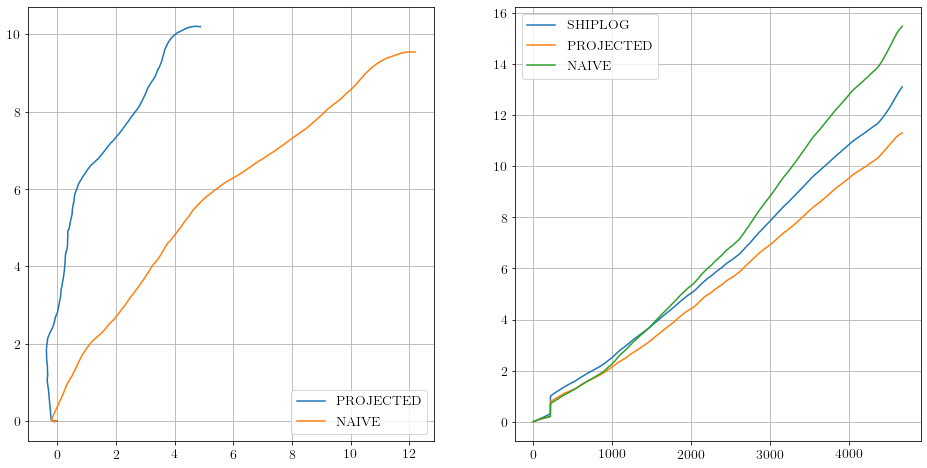

In [1161]:
import pyproj as proj

def projectCoords(lat, lon, flat, flon, projection='epsg:26920'):
    if projection == 'naive':
        y = (lat)*111e3 
        x = (lon*np.cos(lat*np.pi/180))*111e3
        x -=x[0]; y -= y[0]
        fy = flat*111e3
        fx = flon*111e3*np.cos(flat*np.pi/180)
    else:
        #crs_wgs = proj.Proj(init='epsg:4326') # assuming you're using WGS84 geographic
        #crs_wgs = proj.CRS.from_epsg(4326) # assuming you're using WGS84 geographic

        #crs_bng = proj.Proj(init=projection) # use a locally appropriate projected CRS
        crs_bng = proj.CRS.from_epsg(26920)
        crs_bng
        #x, y = proj.transform(crs_wgs, crs_bng, lon, lat)
        transformer = proj.Transformer.from_crs('epsg:4326', projection, always_xy=True)
        x, y = transformer.transform(lon, lat)
        x -= x[0]; y -= y[0]
        #fx, fy = proj.transform(crs_wgs, crs_bng, flon, flat)
        fx, fy = transformer.transform(flon, flat)

    fxv = np.gradient(fx)/np.gradient(fyds*86400)
    fyv = np.gradient(fy)/np.gradient(fyds*86400)
    fxvm = np.mean(np.interp(jday_ts[span], fyds, fxv))
    fyvm = np.mean(np.interp(jday_ts[span], fyds, fyv))
    fang = np.arctan2(fyvm, fxvm)
    theta = -fang
    rotatedpoints = (x*np.cos(theta)-y*np.sin(theta), x*np.sin(theta)+y*np.cos(theta))

    return rotatedpoints[0]/1000, rotatedpoints[1]/1000



cross = 12

span = range(ii[cross,0], ii[cross, 1])

rotatedx, rotatedy = projectCoords(lat_ts[span],lon_ts[span], floatstruct.lats, floatstruct.lons)
rotatedxn, rotatedyn = projectCoords(lat_ts[span],lon_ts[span], floatstruct.lats, floatstruct.lons, projection='naive')

fig, ax = plt.subplots(1,2, figsize=(16,8))
#ax[0].plot(shiplog_ts[span]-shiplog_ts[span[0]], label='SHIPLOG')
ax[0].plot(rotatedx, rotatedy, label='PROJECTED')
ax[0].plot(rotatedxn, rotatedyn, label='NAIVE')
ax[0].grid()
ax[0].legend()


ax[1].plot(shiplog_ts[span]-shiplog_ts[span[0]], label='SHIPLOG')
ax[1].plot(np.sqrt(rotatedx**2 + rotatedy**2), label='PROJECTED')
ax[1].plot(np.sqrt(rotatedxn**2 + rotatedyn**2), label='NAIVE')
ax[1].grid()
ax[1].legend()

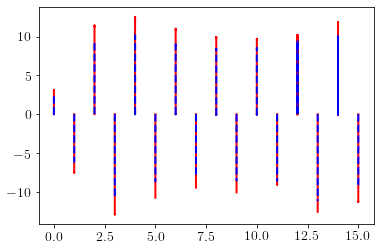

In [1162]:
plt.figure()
for i in range(0,16):
    span = range(ii[i,0], ii[i, 1])
    rotatedx, rotatedy = projectCoords(lat_ts[span],lon_ts[span], floatstruct.lats, floatstruct.lons)
    rotatedxn, rotatedyn = projectCoords(lat_ts[span],lon_ts[span], floatstruct.lats, floatstruct.lons, projection='naive')
    plt.plot(i +0*rotatedy, rotatedy, color='r', linewidth=2)
    plt.plot(i +0*rotatedyn, rotatedyn, color='b',linestyle='--', linewidth=2)
    #plt.xlim(11.9, 12.1)

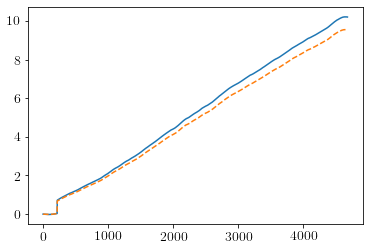

In [1151]:
plt.plot(rotatedy)
plt.plot(rotatedyn, linestyle='--')

/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


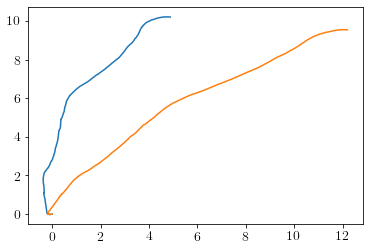

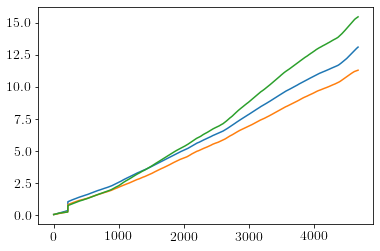

In [1093]:
# setup your projections
crs_wgs = proj.Proj(init='epsg:4326') # assuming you're using WGS84 geographic
crs_bng = proj.Proj(init='epsg:27700') # use a locally appropriate projected CRS
crs_utm = proj.CRS.from_epsg(26920)
# then cast your geographic coordinate pair to the projected system

xn, yn = proj.transform(crs_wgs, crs_utm, lon_ts[span], lat_ts[span])
xn -= xn[0]; yn -= yn[0]
flonsm, flatsm = proj.transform(crs_wgs, crs_utm, floatstruct.lons, floatstruct.lats)

rotatedx, rotatedy = projectCoords(xn,yn, flonsm, flatsm)

plt.plot(rotatedx, rotatedy)



# Do the Naive thing
ynaive = (lat_ts[span])*111e3 
xnaive = (lon_ts[span]*np.cos(lat_ts[span]*np.pi/180))*111e3
xnaive -=xnaive[0]; ynaive -= ynaive[0]

    
flatsm = floatstruct.lats*111e3
flonsm = floatstruct.lons*111e3*np.cos(floatstruct.lats*np.pi/180)

rotatedxn, rotatedyn = projectCoords(xnaive, ynaive, flonsm, flatsm)

plt.plot(rotatedxn, rotatedyn)

plt.figure()
plt.plot(shiplog_ts[span]-shiplog_ts[span[0]])
plt.plot(np.sqrt(rotatedx**2 + rotatedy**2))
plt.plot(np.sqrt(rotatedxn**2 + rotatedyn**2))

#plt.plot(xnaive/1000, ynaive/1000)

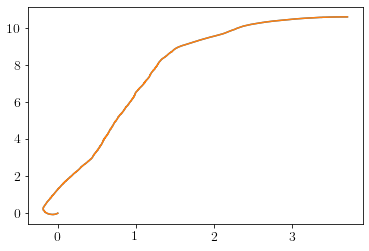

In [1066]:
plt.plot(xn/1000, yn/1000)
plt.plot(xn2/1000, yn2/1000)

#plt.plot(np.abs(rotatedpoints[1])/1000, label='Cross Front Dist.')


In [1059]:
crs_bng

Proj('+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +units=m +no_defs', preserve_units=True)

In [1078]:
crs_26917 = proj.CRS.from_epsg(26920)
crs_26917

<Projected CRS: EPSG:26920>
Name: NAD83 / UTM zone 20N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 66°W to 60°W and NAD83 by country
- bounds: (-66.0, 15.63, -60.0, 84.0)
Coordinate Operation:
- name: UTM zone 20N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [1064]:
lon_ts[span[0]]

-64.17793480175827